In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'shayanriyaz/riceleafs'

Dataset URL: https://www.kaggle.com/datasets/shayanriyaz/riceleafs
License(s): CC0-1.0
100% 14.9G/14.9G [12:00<00:00, 22.1MB/s]
100% 14.9G/14.9G [12:00<00:00, 22.2MB/s]


In [ ]:
# Import library yang dibutuhkan
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from hyperopt import fmin, tpe, hp
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import pathlib
import random
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical

In [ ]:
#Melakukan ekstrak pada dataset
local_zip = '/content/riceleafs.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
source_path = '/content/RiceLeafs'

# train source
source_path_train_Brownspot = os.path.join(source_path, 'train/BrownSpot')
source_path_train_Healthy   = os.path.join(source_path, 'train/Healthy')
source_path_train_Hispa     = os.path.join(source_path, 'train/Hispa')
source_path_train_LeafBlast = os.path.join(source_path, 'train/LeafBlast')

print(f"There are {len(os.listdir(source_path_train_Brownspot))} images of Train Brown Spot.")
print(f"There are {len(os.listdir(source_path_train_Healthy))} images of Train Healthy.")
print(f"There are {len(os.listdir(source_path_train_Hispa))} images of Train Hispa.")
print(f"There are {len(os.listdir(source_path_train_LeafBlast))} images of Train LeafBlast.\n")

# Validation source
source_path_validation_Brownspot  = os.path.join(source_path, 'validation/BrownSpot')
source_path_validation_Healthy    = os.path.join(source_path, 'validation/Healthy')
source_path_validation_Hispa      = os.path.join(source_path, 'validation/Hispa')
source_path_validation_LeafBlast  = os.path.join(source_path, 'validation/LeafBlast')

print(f"There are {len(os.listdir(source_path_validation_Brownspot))} images of Validation Brown Spot.")
print(f"There are {len(os.listdir(source_path_validation_Healthy))} images of Validation Healthy.")
print(f"There are {len(os.listdir(source_path_validation_Hispa))} images of Validation Hispa.")
print(f"There are {len(os.listdir(source_path_validation_LeafBlast))} images of Validation LeafBlast.\n")

There are 418 images of Train Brown Spot.
There are 1191 images of Train Healthy.
There are 452 images of Train Hispa.
There are 623 images of Train LeafBlast.

There are 105 images of Validation Brown Spot.
There are 297 images of Validation Healthy.
There are 113 images of Validation Hispa.
There are 156 images of Validation LeafBlast.



Sample Testing Healthy Rice Leaf:


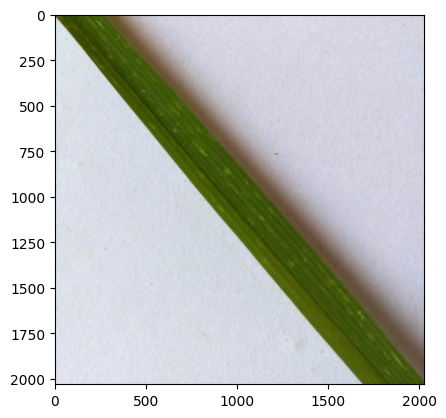

Sample Testing Leaf Blast Rice Leaf:


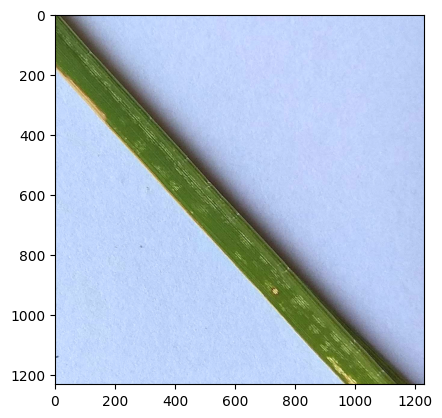

Sample Testing Brownspot Rice Leaf:


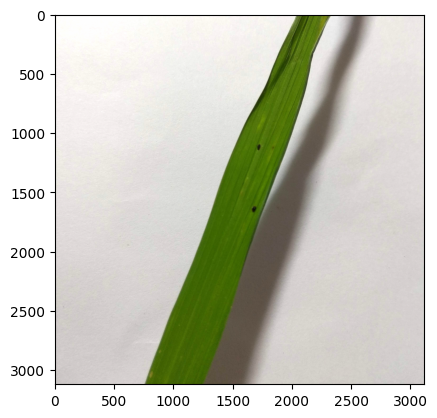

Sample Testing Hispa Rice Leaf:


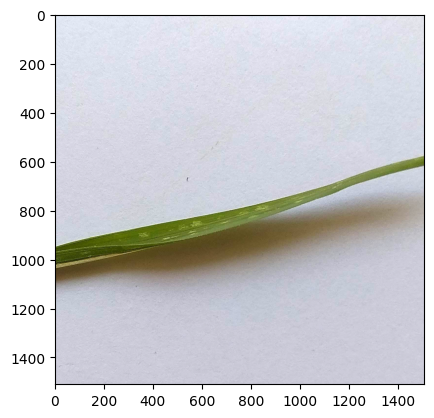

In [ ]:
random_number = random.randint(0, len(os.listdir(source_path_validation_Hispa)))
print("Sample Testing Healthy Rice Leaf:")
plt.imshow(load_img(f"{os.path.join(source_path_train_Healthy, os.listdir(source_path_train_Healthy)[random_number])}"))
plt.show()

print("Sample Testing Leaf Blast Rice Leaf:")
plt.imshow(load_img(f"{os.path.join(source_path_train_LeafBlast , os.listdir(source_path_train_LeafBlast )[random_number])}"))
plt.show()

print("Sample Testing Brownspot Rice Leaf:")
plt.imshow(load_img(f"{os.path.join(source_path_train_Brownspot , os.listdir(source_path_train_Brownspot )[random_number])}"))
plt.show()

print("Sample Testing Hispa Rice Leaf:")
plt.imshow(load_img(f"{os.path.join(source_path_train_Hispa , os.listdir(source_path_train_Hispa)[random_number])}"))
plt.show()

In [ ]:
TRAINING_DIR = os.path.join(source_path, 'train')
VALIDATION_DIR = os.path.join(source_path, 'validation')

In [ ]:
dataset = []
shape = (224, 224)
count = 0
for file in os.listdir(TRAINING_DIR):
  path = os.path.join(TRAINING_DIR, file)
  time = 0
  for k in os.listdir(path):
    image   = load_img(os.path.join(path, k), grayscale=False, color_mode='rgb', target_size = shape)
    image   = img_to_array(image)
    image   = image/255.0
    dataset += [[image, count]]
    time    +=1
  count = count+1

In [ ]:
testset=[]
count=0
for file in os.listdir(VALIDATION_DIR):
    path=os.path.join(VALIDATION_DIR,file)
    t=0
    for im in os.listdir(path):
        image    = load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=shape)
        image    = img_to_array(image)
        image    = image/255.0
        testset  += [[image,count]]
        t        += 1
    count        = count+1

In [ ]:
data,trainlabels = zip(*dataset)
test,testlabels = zip(*testset)

labels1 = to_categorical(trainlabels)
labels  = np.array(labels1)

data    = np.array(data)
test    = np.array(test)

trainx, testx, trainy, testy = train_test_split(data,
                                                labels,
                                                test_size=0.2,
                                                random_state=42)

In [ ]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(2147, 224, 224, 3)
(537, 224, 224, 3)
(2147, 4)
(537, 4)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=30,
                             zoom_range=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.2,
                             shear_range=0.2)

In [ ]:
pretrained_model = tf.keras.applications.DenseNet121(input_shape=(224,224,3),
                                                      include_top=False,
                                                      weights='imagenet')

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Flatten()(pretrained_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
callback = MyCallback()

In [ ]:
his = model.fit(train_datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=200, callbacks=[callback])

Epoch 1/200
68/68 [==============================] - 26s 380ms/step - loss: 0.0399 - accuracy: 0.9902 - val_loss: 1.2382 - val_accuracy: 0.7356
Epoch 2/200
68/68 [==============================] - 26s 373ms/step - loss: 0.0690 - accuracy: 0.9800 - val_loss: 0.7420 - val_accuracy: 0.8156
Epoch 3/200
68/68 [==============================] - 25s 369ms/step - loss: 0.0685 - accuracy: 0.9772 - val_loss: 2.0532 - val_accuracy: 0.5140
Epoch 4/200
68/68 [==============================] - 25s 369ms/step - loss: 0.0781 - accuracy: 0.9753 - val_loss: 0.7588 - val_accuracy: 0.8361
Epoch 5/200
68/68 [==============================] - 25s 371ms/step - loss: 0.0486 - accuracy: 0.9842 - val_loss: 0.7981 - val_accuracy: 0.8268
Epoch 6/200
68/68 [==============================] - 25s 370ms/step - loss: 0.0370 - accuracy: 0.9902 - val_loss: 0.7743 - val_accuracy: 0.8156
Epoch 7/200
68/68 [==============================] - 25s 370ms/step - loss: 0.0308 - accuracy: 0.9898 - val_loss: 0.6541 - val_accuracy:

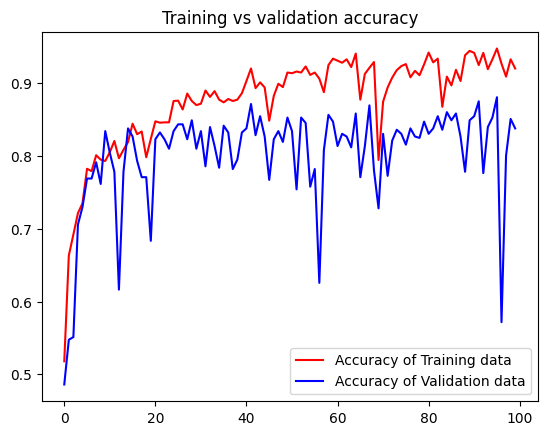

<Figure size 640x480 with 0 Axes>

In [ ]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size =(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)

KeyboardInterrupt: 

In [ ]:
test_img = image.load_img(path, target_size=(224,224))
img_arr = image.img_to_array(test_img)
img_arr = np.expand_dims(img_arr, axis=0)

img_arr /= 255.0

prediksi = model.predict(img_arr)
kelas = np.argmax(prediksi)

In [ ]:
def hasil_prediksi(kelas):
  if kelas == 1:
    print("Tanaman anda terkena penyakit bercak cokelat")
    print("Akurasi prediksi",round((prediksi[0][kelas] * 100),2),"%")
  elif kelas == 2:
    print("Tanaman anda sehat, terus perhatikan kesehatan tanaman anda!")
    print("Akurasi prediksi",round((prediksi[0][kelas] * 100),2),"%")
  elif kelas == 3:
    print("Tanaman anda terkena penyakit hispa")
    print("Akurasi prediksi",round((prediksi[0][kelas] * 100),2),"%")
  else:
    print("Tanaman anda terkena penyakit ledakan daun")
    print("Akurasi prediksi",round((prediksi[0][kelas] * 100),2),"%")

    return hasil_prediksi

In [ ]:
hasil_prediksi(kelas)

In [ ]:
export_dir = 'rice_model'

model.save(export_dir)

In [ ]:
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimizations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/rice_model.tflite')
tflite_model_file.write_bytes(tflite_model)

58793080